In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [1]:

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
#conda install -c conda-forge lightgbm
import lightgbm as lgb


Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
cars = pd.read_csv("/Users/Tingjue/170 project/cars ml.csv")

In [3]:
cars.pop('id')
Y = cars.pop('price').values
X = cars.values[:,1:]
scaler = StandardScaler()
X = scaler.fit_transform(X) #normalization, helps nn model，not so much effect on other two

In [4]:
features = ['year', ' avg_rating', ' count', ' condition', ' cylinders', ' odometer', 
            ' lstm_feature', ' bilstm_feature', ' gru_feature', ' cnn_feature', ' fast_feature', 
            'diesel', ' electric', ' gas', ' hybrid', ' other fuel', ' title_status_encode', 
            ' automatic', 'manual', ' other transmission', ' 4wd', ' fwd', ' rwd', ' color_encode', 
            ' location_encode', 'manufacturer_encode', ' model_encode']

In [351]:
#decision tree for regression, 10 fold cross-validation for evulation.
def decision_tree(train_x,train_y):
    oof_train = np.zeros((len(train_x),), dtype=np.float32) # for recording predicted value
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # split into 10, 9 for train, 1 for test.
    imp = [0]*27
    for fold, (train_index, valid_index) in enumerate(skf.split(train_x, train_y)): 
        model = DecisionTreeRegressor(max_depth=8)
        
        #here train_x, train_y is the data, and train_index are the indexs (the 9 fold) that will be trained
        #we picks up the rows that will be trained for both x and y
        x = train_x[train_index] # train_x[train_index]这是array的用法
        y = train_y[train_index] 
        
        #here valid_index are the indexs (the 1 fold) that will be used for validation.
        val_x = train_x[valid_index] #picks up the rows that will be used for validation
        
        model.fit(x, y) # train model 
    
        importance = model.feature_importances_
        for i in range(len(importance)):
            imp[i] += importance[i]

        pred = model.predict(val_x) # use trained model to predict
        
        pred = pred.reshape((len(pred)))
        oof_train[valid_index] += pred # record predict value
        
    #mse_score = mean_squared_error(train_y, oof_train)
    #print("decision tree mse:",mse_score)
    mae_score = mean_absolute_error(train_y, oof_train)
    print("decision tree mae:",mae_score)
    print('decision tree mape: ', mean_absolute_percentage_error(train_y, oof_train))    
    print("decision tree mbe:", abs(sum(oof_train-train_y)/len(oof_train)))
    print("decision tree r^2:", r2_score(train_y, oof_train)) 
    
    #actual vs predicted
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.plot(oof_train[:100], label='Predict price')
    ax.plot(train_y[:100], label='Actual price')
    ax.set_title('Actual price vs Predict price (DT)')
    ax.set_xlabel('Cars')
    ax.set_ylabel('Prices')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')
    
    #feature importance
    imp = [i/10 for i in imp]
    d = dict(zip(features, imp))
    d = sorted(d.items(), key=lambda x: x[1], reverse=True)
    features_ = []
    imp_ = []
    for i in range(26):
        features_.append(d[i][0])
        imp_.append(d[i][1])
    fig, ax = plt.subplots(1,figsize=(14,8))
    ax.bar(features_, imp_)
    ax.set_title('Feature Importance (DT)')
    ax.set_ylabel('Importance')
    ax.xaxis.set_tick_params(rotation=90)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


decision tree mae: 3094.6078064564836
decision tree mape:  32.1090256507377
decision tree mbe: 12.614999854616595
decision tree r^2: 0.7643314975268232


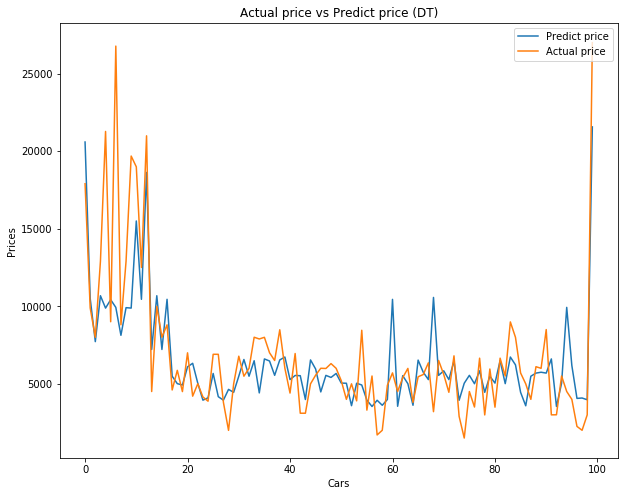

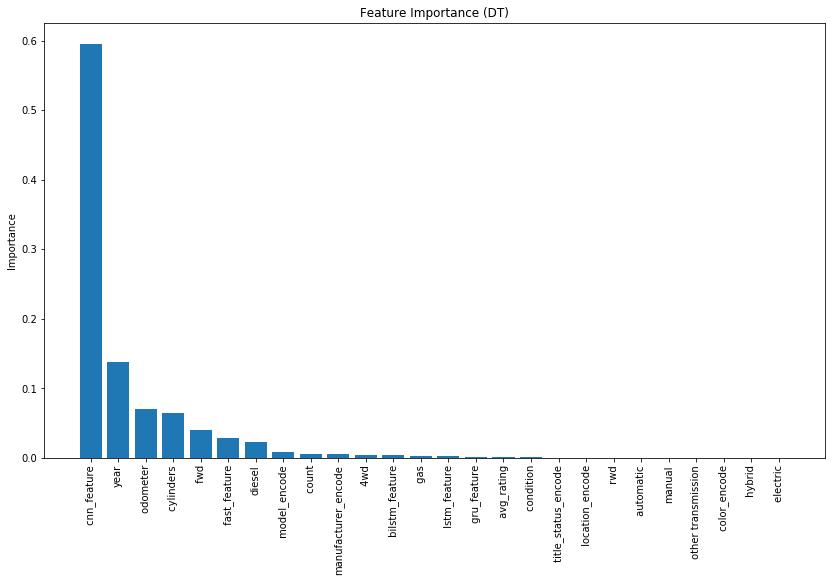

In [352]:
decision_tree(X,Y)

In [9]:
def linear(train_x,train_y):
    oof_train = np.zeros((len(train_x),), dtype=np.float32) # for recording predicted value
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # split into 10, 9 for train, 1 for test.
    imp = [0]*27
    for fold, (train_index, valid_index) in enumerate(skf.split(train_x, train_y)): 
        model = LinearRegression()
        
        #here train_x, train_y is the data, and train_index are the indexs (the 9 fold) that will be trained
        #we picks up the rows that will be trained for both x and y
        x = train_x[train_index] # train_x[train_index]这是array的用法
        y = train_y[train_index] 
        
        #here valid_index are the indexs (the 1 fold) that will be used for validation.
        val_x = train_x[valid_index] #picks up the rows that will be used for validation
        
        model.fit(x, y) # train model 
    
      #  importance = model.feature_importances_
       # for i in range(len(importance)):
      #      imp[i] += importance[i]

        pred = model.predict(val_x) # use trained model to predict
        
        pred = pred.reshape((len(pred)))
        oof_train[valid_index] += pred # record predict value
        
    #mse_score = mean_squared_error(train_y, oof_train)
    #print("decision tree mse:",mse_score)
    mae_score = mean_absolute_error(train_y, oof_train)
    print("linear mae:",mae_score)
    print('linear mae: ', mean_absolute_percentage_error(train_y, oof_train))    
    print("linear mbe:", abs(sum(oof_train-train_y)/len(oof_train)))
    print("linear r^2:", r2_score(train_y, oof_train)) 
    
    #actual vs predicted
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.plot(oof_train[:100], label='Predict price')
    ax.plot(train_y[:100], label='Actual price')
    ax.set_title('Actual price vs Predict price (DT)')
    ax.set_xlabel('Cars')
    ax.set_ylabel('Prices')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')
    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


linear mae: 3271.58702465268
linear mbe: 0.11641070540457034
linear r^2: 0.7612399491221582


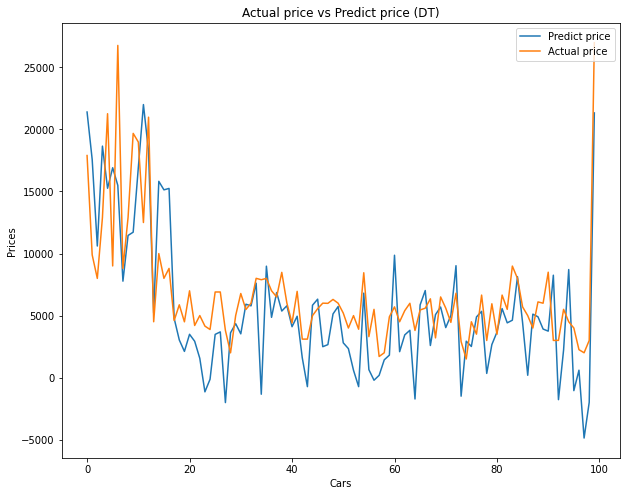

In [10]:
linear(X,Y)

In [658]:
#cars2 = pd.read_csv("/Users/yunjianh/cars ml.csv")

In [659]:
#cars2.pop('id')
#cars2.pop('other fuel')
#cars2.pop('hybrid')

#Y2 = cars2.pop('price').values
#X2 = cars2.values[:,1:]
#scaler = StandardScaler()
#X2 = scaler.fit_transform(X2)

In [595]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
}

In [669]:
#gradient boosting decision tree for regression, 10 fold cross-validation for evulation.
def gbdt_reg(train_x,train_y):
    oof_train = np.zeros((len(train_x),), dtype=np.float32)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    #imp = [0]*25
    imp = [0]*27
    
    for fold, (train_index, valid_index) in enumerate(skf.split(train_x, train_y)):
        x = train_x[train_index]
        y = train_y[train_index]
        val_x = train_x[valid_index]
        val_y = train_y[valid_index]
        
        lgb_train = lgb.Dataset(x, y)
        lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)
        model = lgb.train(params,
                        lgb_train,
                        num_boost_round=50000, 
                        valid_sets=lgb_eval,
                        verbose_eval=1000,
                        early_stopping_rounds=300) # if not helps the result after 300 rounds, just stop 
        
        importance = model.feature_importance()
        print(len(importance))
        for i in range(len(importance)):
            imp[i] += importance[i]

        pred = model.predict(val_x)
        pred = pred.reshape((len(pred)))
        oof_train[valid_index] += pred
    
    #mse_score = mean_squared_error(train_y, oof_train)
    #print("gbdt mse:",mse_score)
    mae_score = mean_absolute_error(train_y, oof_train)  
    print("gbdt mae:",mae_score)
    print("gbdt mbe:", abs(sum(oof_train-train_y)/len(oof_train)))
    print("gbdt r^2:", r2_score(train_y, oof_train))
    
    #Actual vs predict
    fig = plt.figure(1, (10,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(oof_train[:100], label='Predict price')
    ax.plot(train_y[:100], label='Actual price')
    ax.set_title('Actual price vs Predict price (GBDT)')
    ax.set_xlabel('Cars')
    ax.set_ylabel('Prices')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')
    
    #feature importance
    imp = [i for i in imp]  
    d = dict(zip(features, imp))
    d = sorted(d.items(), key=lambda x: x[1], reverse=True)
    features_ = []
    imp_ = []
    for i in range(len(d)):
        features_.append(d[i][0])
        imp_.append(d[i][1])
    fig, ax = plt.subplots(1,figsize=(14,8))
    ax.bar(features_, imp_)
    ax.set_title('Feature Importance (GBDT)')
    ax.set_ylabel('Importance')
    ax.xaxis.set_tick_params(rotation=90)
    
    #cumulative feature importance
    fig, ax = plt.subplots(1,figsize=(14,8))
    raw_df = pd.DataFrame(imp_)
    normed_df = raw_df.div(raw_df.sum(axis=0), axis=1)
    sorted_importances = normed_df
    sorted_features = features_
    cumulative_importances = np.cumsum(sorted_importances)
    plt.plot(sorted_features, cumulative_importances, 'g-')
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    plt.xticks(sorted_features, rotation = 'vertical')
    plt.ylabel('Importance'); plt.title('Cumulative Feature Importance (GBDT)');   


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 1.09476e+07
Early stopping, best iteration is:
[1227]	valid_0's l2: 1.08585e+07
27
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 1.15072e+07
Early stopping, best iteration is:
[1103]	valid_0's l2: 1.14822e+07
27
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 9.67689e+06
[2000]	valid_0's l2: 9.6547e+06
Early stopping, best iteration is:
[1731]	valid_0's l2: 9.63034e+06
27
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 1.05278e+07
[2000]	valid_0's l2: 1.04269e+07
Early stopping, best iteration is:
[1881]	valid_0's l2: 1.04133e+07
27
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 1.09756e+07
Early stopping, best iteration is:
[1458]	valid_0's l2: 1.08951e+07
27
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 1.24149e+07
Early stop

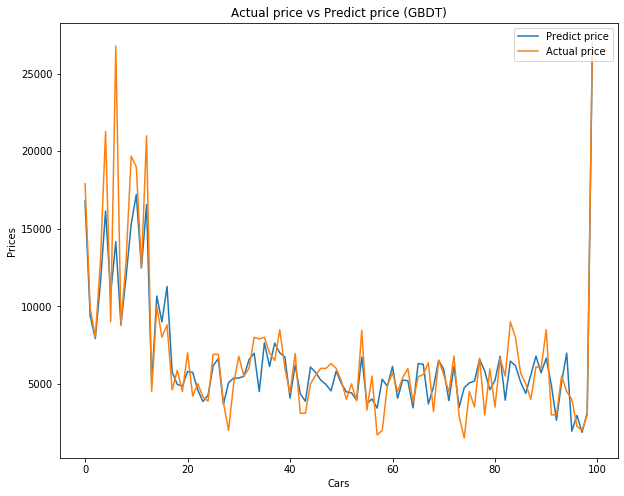

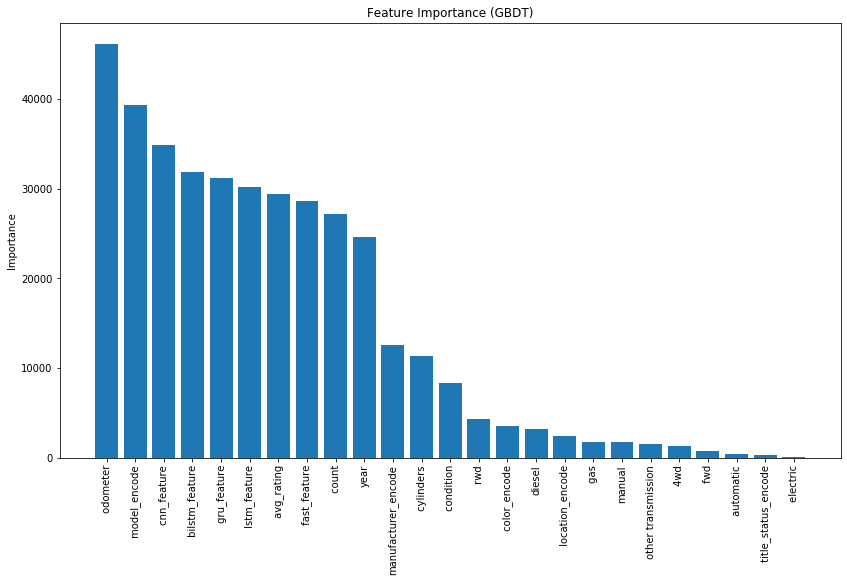

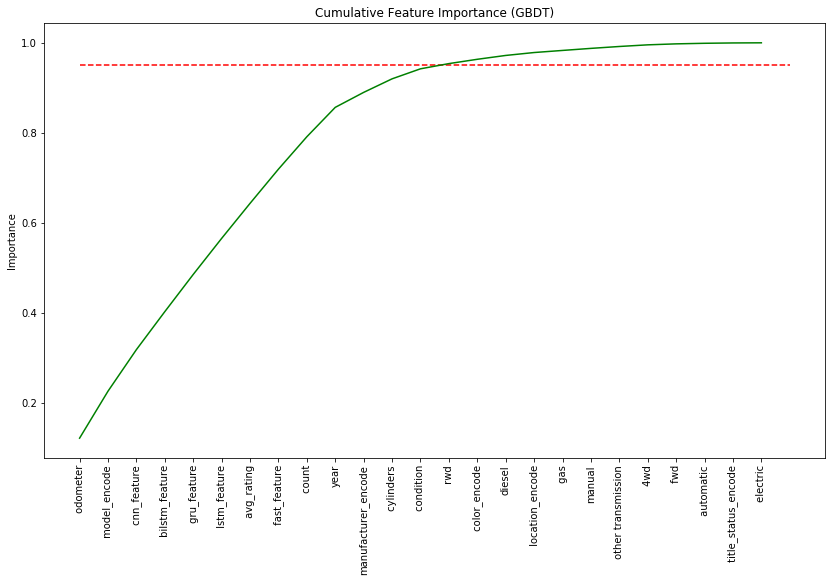

In [670]:
gbdt_reg(X,Y)

In [342]:
#construct nn
def nn(maxlen):
    inputs = Input(shape=(maxlen,)) #num of variables 
    
    #layers
    x = Dense(60,activation='relu')(inputs)
    x = Dense(60, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    # if add more layers leading to the decrease of accuracy, stop adding layers.
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(loss='mse', optimizer=Adam(1e-2))
    return model

In [244]:
#neural network for regression, 10 fold cross-validation for evulation.
def nn_reg(train_x,train_y):
    oof_train = np.zeros((len(train_x),), dtype=np.float32)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, valid_index) in enumerate(skf.split(train_x, train_y)):
        model = nn(len(train_x[0]))
        x = train_x[train_index]
        y = train_y[train_index]
        val_x = train_x[valid_index]
        
        model.fit(x, y,batch_size=32,epochs=5) # backward
        
        pred = model.predict(val_x,batch_size=32)
        pred = pred.reshape((len(pred)))
        oof_train[valid_index] += pred
        
    #mse_score = mean_squared_error(train_y, oof_train)
    #print("nn mse:",mse_score)
    mae_score = mean_absolute_error(train_y, oof_train)
    print("nn mae:",mae_score)
    print("nn mbe:", abs(sum(oof_train-train_y)/len(oof_train)))
    print("nn r^2:", r2_score(train_y, oof_train))
    
    #actual vs predict
    fig = plt.figure(1, (10,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(oof_train[:100], label='Predict price')
    ax.plot(train_y[:100], label='Actual price')
    ax.set_title('Actual price vs Predict price (NN)')
    ax.set_xlabel('Cars')
    ax.set_ylabel('Prices')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Epoch 1/5
53576/53576 [==============================] - 4s 67us/step - loss: 25693275.5620
Epoch 2/5
53576/53576 [==============================] - 3s 56us/step - loss: 18390299.7085
Epoch 3/5
53576/53576 [==============================] - 3s 56us/step - loss: 17714210.7744
Epoch 4/5
53576/53576 [==============================] - 3s 54us/step - loss: 17231899.0023
Epoch 5/5
53576/53576 [==============================] - 3s 55us/step - loss: 16915703.2193
Epoch 1/5
53647/53647 [==============================] - 4s 66us/step - loss: 24864134.1789
Epoch 2/5
53647/53647 [==============================] - 3s 56us/step - loss: 18268744.3558
Epoch 3/5
53647/53647 [==============================] - 3s 56us/step - loss: 17543219.0682
Epoch 4/5
53647/53647 [==============================] - 3s 54us/step - loss: 17154445.8314
Epoch 5/5
53647/53647 [==============================] - 3s 55us/step - loss: 16938641.4219
Epoch 1/5
53751/53751 [==============================] - 3s 65us/step - loss: 25

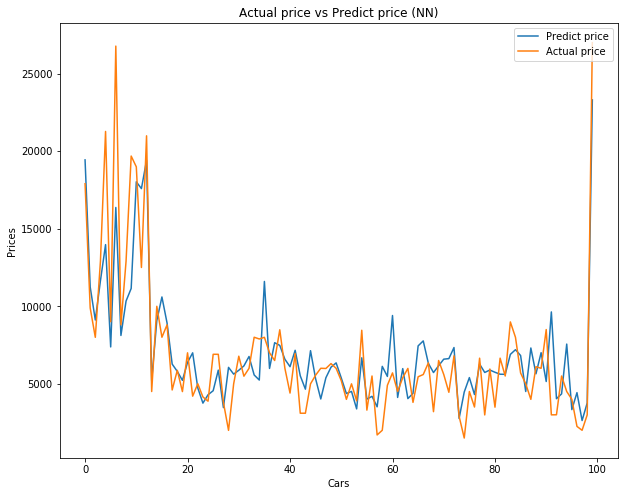

In [245]:
nn_reg(X,Y)